In [ ]:
import os
# os.environ["MKL_NUM_THREADS"] = "8"
# os.environ["NUMEXPR_NUM_THREADS"] = "8"
# os.environ["OMP_NUM_THREADS"] = "8"

import numpy as np
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
import cv2
import timeit
from os import path, makedirs, listdir
import sys
sys.setrecursionlimit(10000)
from multiprocessing import Pool
from skimage.morphology import square, dilation, erosion
from skimage import io

from shapely.wkt import loads
from shapely.geometry import mapping, Polygon

# import matplotlib.pyplot as plt
# import seaborn as sns

import json

In [ ]:
masks_dir = 'masks'

base_dirs = ['tier3', 'test', 'hold', 'train']


damage_dict = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    #"un-classified": 1 # ?
}

In [ ]:
def mask_for_polygon(poly, im_size=(1024, 1024)):
    img_mask = np.zeros(im_size, np.uint8)
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords)]
    interiors = [int_coords(pi.coords) for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


def process_image(json_file):
    js1 = json.load(open(json_file))
    js2 = json.load(open(json_file.replace('_pre_disaster', '_post_disaster')))
    # print('Loaded JSON file')

    msk = np.zeros((1024, 1024), dtype='uint8')
    msk_damage = np.zeros((1024, 1024), dtype='uint8')
    # print('created empty masks')

    for feat in js1['features']['xy']:
        poly = loads(feat['wkt'])
        _msk = mask_for_polygon(poly)
        msk[_msk > 0] = 255

    # print('polygons for pre loaded')

    for feat in js2['features']['xy']:
        poly = loads(feat['wkt'])
        subtype = feat['properties']['subtype']
        _msk = mask_for_polygon(poly)
        msk_damage[_msk > 0] = damage_dict[subtype]
    # print('polygons for post loaded')


    cv2.imwrite(json_file.replace('labels', 'masks').replace('_pre_disaster.json', '_pre_disaster.png'), msk, [cv2.IMWRITE_PNG_COMPRESSION, 9])
    cv2.imwrite(json_file.replace('labels', 'masks').replace('_pre_disaster.json', '_post_disaster.png'), msk_damage, [cv2.IMWRITE_PNG_COMPRESSION, 9])

    # print('created')

In [ ]:
all_files = []
for d in base_dirs:
    makedirs(path.join(d, masks_dir), exist_ok=True)
    for f in sorted(listdir(path.join(d, 'images'))):
        if '_pre_disaster.png' in f:
            all_files.append(path.join(d, 'labels', f.replace('_pre_disaster.png', '_pre_disaster.json')))

print('Files loaded.. Now we will create the masks!!!')

Files loaded.. Now we will create the masks!!!


In [ ]:
for json_file in all_files:
    process_image(json_file)

In [ ]:
def count_pixels(mask_dir, original_dir):
    results = []
    for file in os.listdir(mask_dir):
        if '_post_' in file:  # Process only files with '_post_' in the filename
            path = os.path.join(mask_dir, file)
            mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            unique, counts = np.unique(mask, return_counts=True)
            pixel_counts = dict(zip(unique, counts))
            total_pixels = mask.size
            row = [file, original_dir]  # Include the file name and original directory
            for i in range(6):
                row.append(pixel_counts.get(i, 0))
            row.append(total_pixels - sum(row[1:8]))
            results.append(row)
    return results

In [ ]:
def move_related_files(base_dir, file, dest_dir):
    for subdir in ['masks', 'images', 'labels']:
        # Adjust the file name based on the subdir
        if subdir == 'labels':
            related_file = file.replace('.png', '.json')
        else:
            related_file = file

        # Move the file
        src_path = os.path.join(base_dir, subdir, related_file)
        dest_path = os.path.join(dest_dir, subdir, related_file)
        if os.path.exists(src_path):
            if not os.path.exists(os.path.dirname(dest_path)):
                os.makedirs(os.path.dirname(dest_path))
            shutil.move(src_path, dest_path)

def move_files(base_dirs, dest_dirs, keywords):
    for base_dir in base_dirs:
        mask_dir = os.path.join(base_dir, 'masks')
        for file in os.listdir(mask_dir):
            if any(keyword in file for keyword in keywords) and ('_pre_' in file or '_post_' in file):
                dest_dir = dest_dirs['A']
            else:
                dest_dir = dest_dirs['B']

            # Move the current mask file and its related files
            move_related_files(base_dir, file, dest_dir)

            # Find and move the corresponding 'post' or 'pre' file
            if '_pre_' in file:
                related_file = file.replace('_pre_', '_post_')
            else:
                related_file = file.replace('_post_', '_pre_')

            move_related_files(base_dir, related_file, dest_dir)

def count_pixels(mask_dir, original_dir):
    results = []
    for file in os.listdir(mask_dir):
        if '_post_' in file:  # Process only files with '_post_' in the filename
            path = os.path.join(mask_dir, file)
            mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            unique, counts = np.unique(mask, return_counts=True)
            pixel_counts = dict(zip(unique, counts))
            total_pixels = mask.size
            row = [file, original_dir]  # Include the file name and original directory
            for i in range(6):
                row.append(pixel_counts.get(i, 0))
            # Calculate sum for pixel counts only (excluding the file name and original directory)
            row.append(total_pixels - sum(row[2:8]))
            results.append(row)
    return results

The main Idea was to do with A and B different train of the models because A and B has different disasters. But in the end I used a mix of all these. You can see that when I am using patchify in the patchify notebook I mixing A and B but I removed the images with no buildings. I keeped this code because it took me so much time to do for all these images, because the dataset is huge.

In [ ]:
dest_dirs = {'A': 'A', 'B': 'B'}
keywords = ['tornado', 'tsunami', 'hurricane', 'earthquake']

# Step 1: Move files into A and B based on keywords
move_files(base_dirs, dest_dirs, keywords)

# Step 2: Count pixels in masks of A and B, including the currently directory
results_A = count_pixels(os.path.join('A', 'masks'), 'A')
results_B = count_pixels(os.path.join('B', 'masks'), 'B')

# Step 3: Write results to CSV files
columns = ['name', 'original_dir', 'pixels_0', 'pixels_1', 'pixels_2', 'pixels_3', 'pixels_4', 'pixels_5', 'pixels_others']
pd.DataFrame(results_A, columns=columns).to_csv('A_masks_pixel_counts.csv', index=False)
pd.DataFrame(results_B, columns=columns).to_csv('B_masks_pixel_counts.csv', index=False)

In [ ]:
def count_pixels(mask_dir, original_dir):
    results = []
    for file in os.listdir(mask_dir):
        if '_post_' in file:  # Process only files with '_post_' in the filename
            path = os.path.join(mask_dir, file)
            mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            unique, counts = np.unique(mask, return_counts=True)
            pixel_counts = dict(zip(unique, counts))
            total_pixels = mask.size
            row = [file, original_dir]  # Include the file name and the currently directory
            for i in range(6):
                row.append(pixel_counts.get(i, 0))
            # Calculate sum for pixel counts only (excluding the file name and currently directory)
            row.append(total_pixels - sum(row[2:8]))
            results.append(row)
    return results

# Step 2: Count pixels in masks of A and B, including the currently directory
results_A = count_pixels(os.path.join('A', 'masks'), 'A')
results_B = count_pixels(os.path.join('B', 'masks'), 'B')

# Step 3: Write results to CSV files
columns = ['name', 'original_dir', 'pixels_0', 'pixels_1', 'pixels_2', 'pixels_3', 'pixels_4', 'pixels_5', 'pixels_others']
pd.DataFrame(results_A, columns=columns).to_csv('A_masks_pixel_counts.csv', index=False)
pd.DataFrame(results_B, columns=columns).to_csv('B_masks_pixel_counts.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
def plotter(dfs):
    total_counts = dfs[['background','no-damage', 'minor-damage', 'major-damage', 'destroyed']].sum()
    average_counts = dfs[['background','no-damage', 'minor-damage', 'major-damage', 'destroyed']].mean()
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    total_counts.plot(kind='bar', ax=ax[0], color='skyblue')
    ax[0].set_title('Total Counts per Pixel Class')
    ax[0].set_xlabel('Pixel Class')
    ax[0].set_ylabel('Total Counts')

    average_counts.plot(kind='bar', ax=ax[1], color='lightgreen')
    ax[1].set_title('Average Counts per Pixel Class')
    ax[1].set_xlabel('Pixel Class')
    ax[1].set_ylabel('Average Counts')

    plt.tight_layout()
    plt.show()

    return total_counts, average_counts_per_image


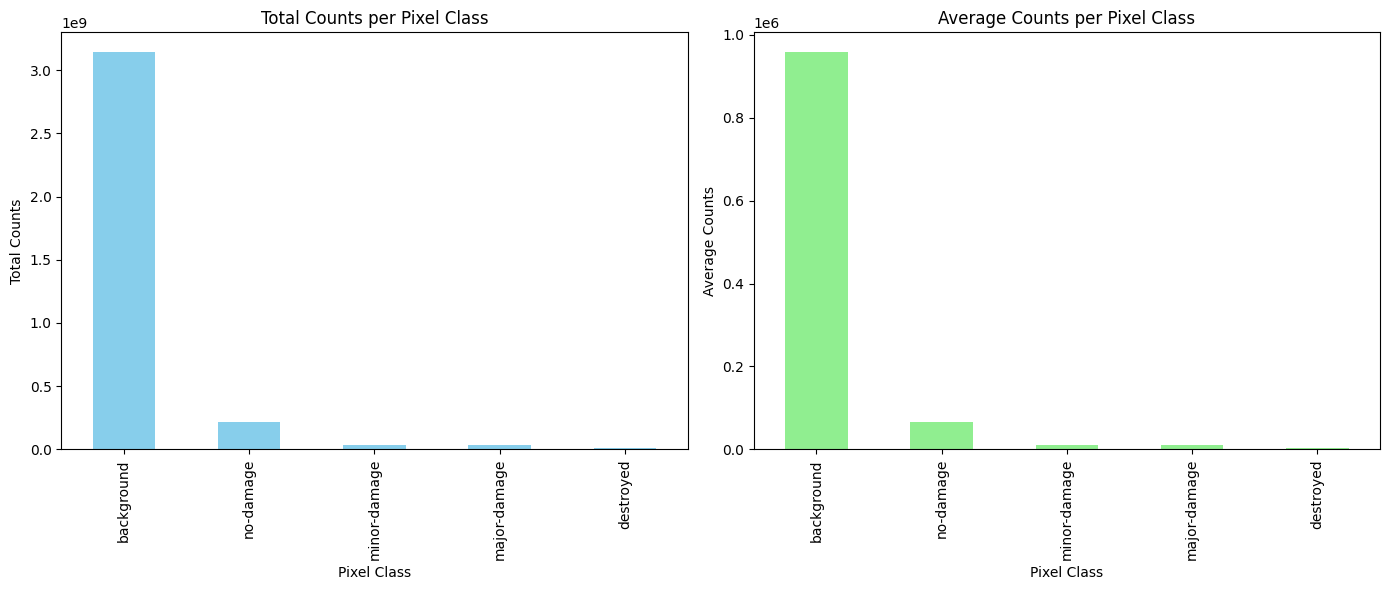

(background      3142792142
 no-damage        217348146
 minor-damage      31977326
 major-damage      34426584
 destroyed         11736506
 dtype: int64,
 pixels_0         958460.549558
 pixels_1          66284.887466
 pixels_2           9752.157975
 pixels_3          10499.110704
 pixels_4           3579.294297
 pixels_5              0.000000
 pixels_others         0.000000
 dtype: float64)

In [ ]:
import pandas as pd

csv_file = 'A_masks_pixel_counts.csv'
df_A = pd.read_csv(csv_file)
plotter(df_A)

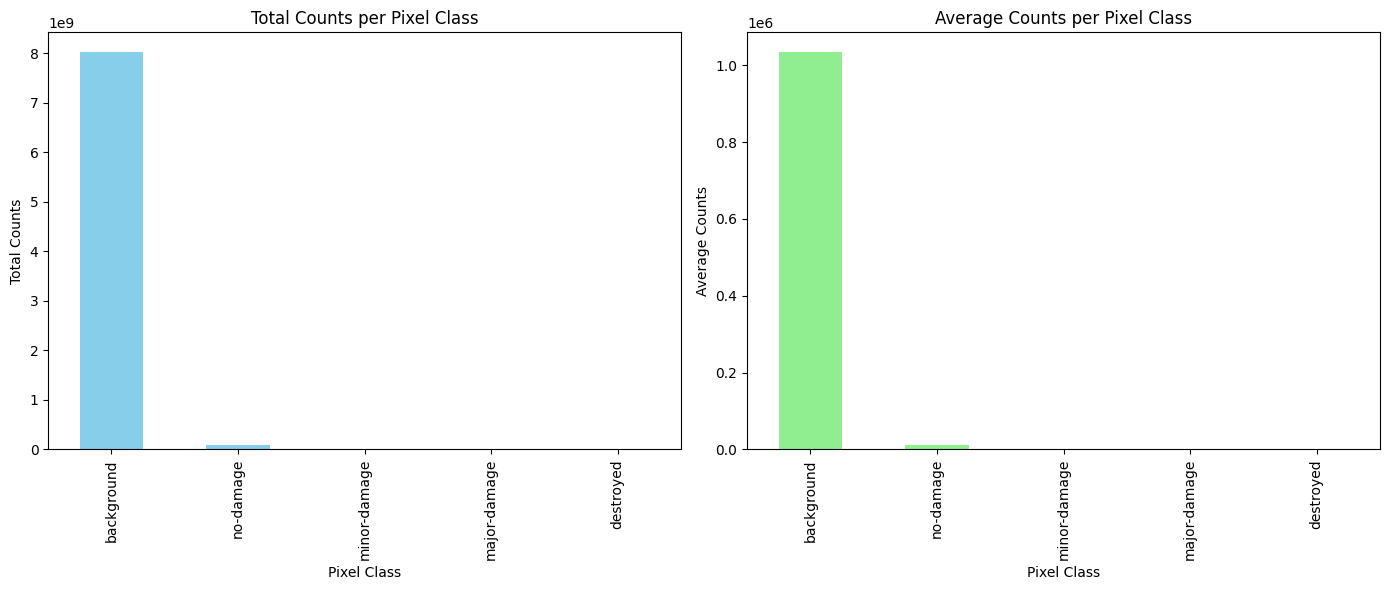

(background      8017173960
 no-damage         95654891
 minor-damage       3545620
 major-damage       3268233
 destroyed         12064176
 dtype: int64,
 pixels_0         958460.549558
 pixels_1          66284.887466
 pixels_2           9752.157975
 pixels_3          10499.110704
 pixels_4           3579.294297
 pixels_5              0.000000
 pixels_others         0.000000
 dtype: float64)

In [ ]:
csv_file = 'B_masks_pixel_counts.csv'
df_B = pd.read_csv(csv_file)
plotter(df_B)

We can see that both folders have many pixels with no buildings so this is why I used patchify and mixed A and B and then removed images with no buildings to the whole image.